# Airbus Ship-Data 

Source: Architecting ML on AWS: 

Write-Up:https://github.com/aws-samples/amazon-sagemaker-architecting-for-ml/blob/master/Writeups/Object%20Detection.md 
Starter Code: https://github.com/aws-samples/amazon-sagemaker-architecting-for-ml/blob/master/Starter-Code/ship-data-transformation.ipynb

In [1]:
#hide
!pip install -Uqq fastbook
!pip install fastcore==1.0.12 #This right here
import fastbook
fastbook.setup_book()

  Using cached fastcore-1.0.12-py3-none-any.whl (40 kB)
  Attempting uninstall: fastcore
    Found existing installation: fastcore 1.1.2
    Uninstalling fastcore-1.1.2:
      Successfully uninstalled fastcore-1.1.2
ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

nbdev 1.1.2 requires fastcore>=1.1.0, but you'll have fastcore 1.0.12 which is incompatible.
fastai 2.0.16 requires fastcore>=1.1.0, but you'll have fastcore 1.0.12 which is incompatible.


In [ ]:
# #hide
# !pip install -Uqq fastbook
# import fastbook
# fastbook.setup_book()

In [2]:
#hide
from fastbook import *
from fastai.vision.widgets import *
from pathlib import Path

# From Model to Production

## Gathering Data

Download Dataset from Kaggle. (Create an account, Create API key, download kaggle.json to this instance, accept Kaggle Terms). 
The dataset is 30GB zip file. Make sure you increase EBS volume size to 100+

## Test Downloaded Image


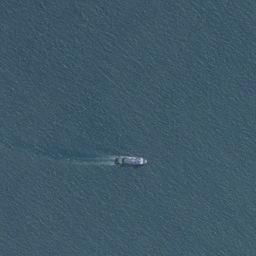

In [3]:
im = Image.open('images/ship-data/train_v2/000155de5.jpg')
im.to_thumb(256,256)

## From Data to DataLoaders

In [4]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


### Split Training Data into ShipYes/ShipNo Folders

In [5]:
masks = pd.read_csv('./images/ship-data/train_ship_segmentations_v2.csv')
print(masks.shape[0], 'masks found')
print(masks['ImageId'].value_counts().shape[0])
masks.head(3)

231723 masks found
192556


,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733 33 268501 33 269269 33 270037 33 270805 33 271573 33 272341 33 273109 33 273877 33 274645 33 275413 33 276181 33 276949 33 277716 34 278484 34 279252 33 280020 33 280788 33 281556 33 282324 33 283092 33 283860 33 284628 33 285396 33 286164 33 286932 33 287700 33 288468 33 289236 33 290004 33 290772 33 291540 33 292308 33 293076 33 293844 33 294612 33 295380 33 296148 33 296916 33 297684 33 298452 33 299220 33 299988 33 300756 33 301524 33 302292 33 303060 33 303827 34 304595 34 305363 33 306131 33 306899 33 307667 33 308435 33 309203 33 309971...


### Prepare Folder of Images with Ships

In [6]:
images_with_ship = masks.ImageId[masks.EncodedPixels.isnull()==False]
images_with_ship = np.unique(images_with_ship.values)
print('There are ' +str(len(images_with_ship)) + ' image files with masks')


There are 42556 image files with masks


In [7]:
images_with_ship

array(['000155de5.jpg', '000194a2d.jpg', '00021ddc3.jpg', ..., 'fffcb6464.jpg', 'fffd924fb.jpg', 'fffdd2377.jpg'], dtype=object)

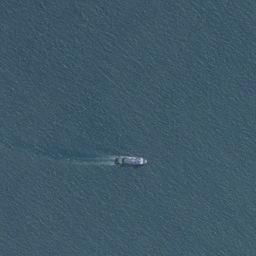

In [8]:
im = Image.open('images/ship-data/train_v2/'+ images_with_ship[0])
im.to_thumb(256,256)

In [10]:
import shutil
import os

# maxfiles = len(images_with_ship)

maxfiles = 1010

dirname = 'train-s' + str(maxfiles)
os.mkdir ('./images/ship-data/' + dirname)
os.mkdir ('./images/ship-data/' + dirname + '/shipyes')

count = 0
while count < maxfiles:
    # print(images_with_ship[count])
    shutil.copy2('./images/ship-data/train_v2/' + images_with_ship[count], './images/ship-data/'+ dirname + '/shipyes')
    count += 1

In [11]:
path = Path('./images/ship-data/'+ dirname)
path

Path('images/ship-data/train-s1010')

In [12]:
fnames = get_image_files(path)

In [93]:
# e.g. get_image_files(path, 'folder')
get_image_files??

In [13]:
fnames

(#1010) [Path('images/ship-data/train-s1010/shipyes/04d06cdf1.jpg'),Path('images/ship-data/train-s1010/shipyes/063c4aa67.jpg'),Path('images/ship-data/train-s1010/shipyes/0002756f7.jpg'),Path('images/ship-data/train-s1010/shipyes/0190215b2.jpg'),Path('images/ship-data/train-s1010/shipyes/00a52cd2a.jpg'),Path('images/ship-data/train-s1010/shipyes/0542423b0.jpg'),Path('images/ship-data/train-s1010/shipyes/003b48a9e.jpg'),Path('images/ship-data/train-s1010/shipyes/05828714b.jpg'),Path('images/ship-data/train-s1010/shipyes/020128a8d.jpg'),Path('images/ship-data/train-s1010/shipyes/0178a78ec.jpg')...]

### Prepare Folder of Images without Ships

In [14]:
images_without_ship = masks.ImageId[masks.EncodedPixels.isnull()==True]
images_without_ship = np.unique(images_without_ship.values)
print('There are ' +str(len(images_without_ship)) + ' image files with NO masks')


images_without_ship

There are 150000 image files with NO masks


array(['00003e153.jpg', '0001124c7.jpg', '0001b1832.jpg', ..., 'ffff6e525.jpg', 'ffffc50b4.jpg', 'ffffe97f3.jpg'], dtype=object)

In [15]:

# maxfiles = len(images_without_ship)

maxfiles = 1010

os.mkdir ('./images/ship-data/' + dirname + '/shipno')

count = 0
while count < maxfiles:
    # print(images_without_ship[count])
    shutil.copy2('./images/ship-data/train_v2/' + images_without_ship[count], './images/ship-data/'+ dirname + '/shipno')
    count += 1

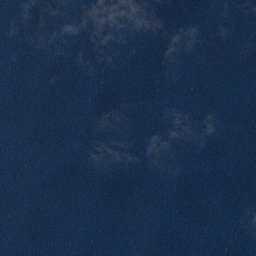

In [16]:
im = Image.open('images/ship-data/train_v2/'+ images_without_ship[0])
im.to_thumb(256,256)

In [17]:
fnames = get_image_files(path)
fnames

(#2020) [Path('images/ship-data/train-s1010/shipno/00fb4ec4c.jpg'),Path('images/ship-data/train-s1010/shipno/0105cf277.jpg'),Path('images/ship-data/train-s1010/shipno/0130673b8.jpg'),Path('images/ship-data/train-s1010/shipno/0045a0833.jpg'),Path('images/ship-data/train-s1010/shipno/00383c855.jpg'),Path('images/ship-data/train-s1010/shipno/0176ce7b1.jpg'),Path('images/ship-data/train-s1010/shipno/009d02050.jpg'),Path('images/ship-data/train-s1010/shipno/019bd7ee0.jpg'),Path('images/ship-data/train-s1010/shipno/018ce6938.jpg'),Path('images/ship-data/train-s1010/shipno/01715451e.jpg')...]

### Ignore section below. They're some debug prints to understand the API

In [18]:
fnames[500]

Path('images/ship-data/train-s1010/shipno/019491575.jpg')

In [19]:
fnames[0]


Path('images/ship-data/train-s1010/shipno/00fb4ec4c.jpg')

In [20]:
fnames[0].parents[0].stem

'shipno'

## Create DataBlock then DataLoader

In [21]:
def label_func(fname):
    # print ("FName is:" + fname)
    #print(fname)
    #print(str(fname).find("shipno"))
    return "shipno" if str(fname).find("shipno") != -1 else "shipyes"

In [22]:
label_func(fnames[500])

'shipno'

In [23]:
label_func(Path('./images/ship-data/train-s42556/shipno/1dcbe44b2.jpg'))

'shipno'

In [24]:
label_func(Path('./images/ship-data/train-s42556/shipyes/000155de5.jpg'))

'shipyes'

In [25]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=label_func,
    item_tfms=Resize(256))

In [26]:
dls = bears.dataloaders(path)

In [27]:
bears.summary(path)

Setting-up type transforms pipelines
Found 2020 items
2 datasets of sizes 1616,404
Setting up Pipeline: PILBase.create
Setting up Pipeline: label_func -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      images/ship-data/train-s1010/shipno/00887bc15.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=768x768
  Pipeline: label_func -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      images/ship-data/train-s1010/shipno/00887bc15.jpg
    applying label_func gives
      shipno
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(0)

Final sample: (PILImage mode=RGB size=768x768, TensorCategory(0))


Setting up after_item: Pipeline: Resize -- {'size': (256, 256), 'method': 'crop', 'pad_mode': 'reflection', 'resamples': (2, 0), 'p': 1.0} -> ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipe

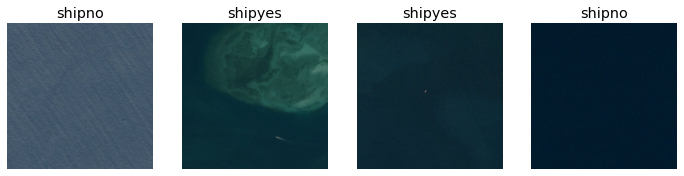

In [28]:
dls.valid.show_batch(max_n=4, nrows=1)

### Skip Sections Below. We have a lot of data. So, hopefully no data augmentation

In [ ]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

In [ ]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

In [ ]:
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

Data Augmentation

In [ ]:
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [ ]:
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)

## Training Your Model, and Using It to Clean Your Data

In [29]:
dls.loss_func

FlattenedLoss of CrossEntropyLoss()

In [71]:
f1_score = F1Score()
precsn_score = Precision()
recall_score = Recall()

In [72]:
learn = cnn_learner(dls, resnet18, metrics=[error_rate, f1_score, precsn_score, recall_score ])
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,f1_score,precision_score,recall_score,time
0,0.778749,0.384335,0.150990,0.850123,0.882653,0.819905,00:18


epoch,train_loss,valid_loss,error_rate,f1_score,precision_score,recall_score,time
0,0.427874,0.410233,0.126238,0.867532,0.959770,0.791469,00:24
1,0.327769,0.289826,0.091584,0.911695,0.918269,0.905213,00:24
2,0.220654,0.303956,0.099010,0.900990,0.943005,0.862559,00:24
3,0.148230,0.304924,0.096535,0.904645,0.934343,0.876777,00:24


In [56]:
cnn_learner??

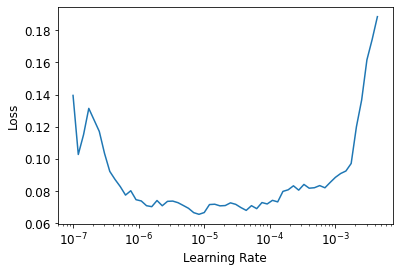

In [162]:
lr_min,lr_steep = learn.lr_find()

In [73]:
print(f"learning rate Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

learning rate Minimum/10: 3.98e-05, steepest point: 9.12e-07


In [44]:
learn.fine_tune??


In [59]:
learn.fine_tune(4, base_lr=9.12e-07)


epoch,train_loss,valid_loss,error_rate,time
0,0.022009,0.250638,0.061881,00:36


epoch,train_loss,valid_loss,error_rate,time
0,0.030057,0.201406,0.051980,00:50
1,0.023967,0.228119,0.061881,00:50
2,0.019662,0.227267,0.059406,00:50
3,0.014285,0.208820,0.059406,00:50


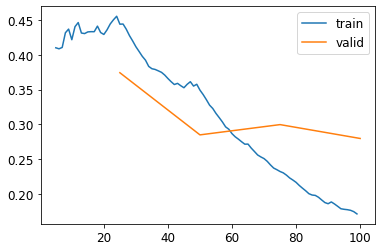

In [31]:
learn.recorder.plot_loss()


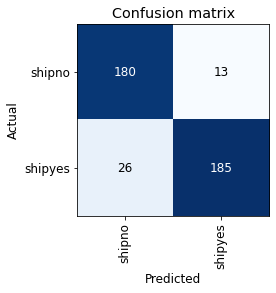

In [32]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

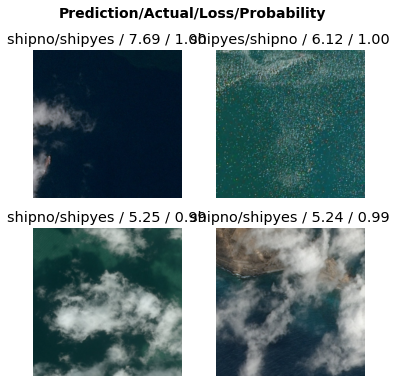

In [33]:
interp.plot_top_losses(4, nrows=2)

In [34]:
from fastai.callback.fp16 import *
learn = cnn_learner(dls, resnet50, metrics=error_rate).to_fp16()
learn.fine_tune(4, freeze_epochs=3)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /home/ec2-user/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


epoch,train_loss,valid_loss,error_rate,time
0,0.933860,0.441855,0.138614,00:36
1,0.654624,0.493195,0.141089,00:36
2,0.494337,0.441765,0.148515,00:37


epoch,train_loss,valid_loss,error_rate,time
0,0.253352,0.401214,0.106436,00:50
1,0.218574,0.261229,0.074257,00:50
2,0.147137,0.169152,0.059406,00:51
3,0.096956,0.166538,0.054455,00:50


TypeError: 'NoneType' object is not iterable

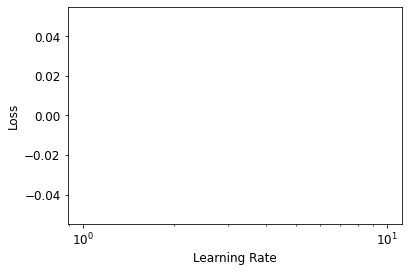

In [60]:
lr_min,lr_steep = learn.lr_find()

In [36]:
print(f"learning rate Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

NameError: name 'lr_min' is not defined

In [50]:
learn.fine_tune(4, base_lr=9.12010818865383e-07)

epoch,train_loss,valid_loss,error_rate,time
0,0.021724,0.429738,0.100000,00:28


epoch,train_loss,valid_loss,error_rate,time
0,0.022524,0.422440,0.093333,00:38
1,0.019258,0.435324,0.096667,00:38
2,0.017490,0.419523,0.096667,00:38
3,0.019125,0.415497,0.090000,00:38


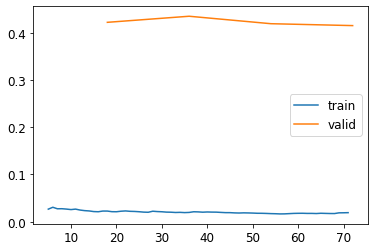

In [51]:
learn.recorder.plot_loss()

In [ ]:
# plot graph of learning rate against iterations

#learn.sched.plot_lr()

In [ ]:
#learn.sched.plot()
# plots the loss against the learning rate

In [52]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 3e-3)
learn.unfreeze()
learn.fit_one_cycle(12, lr_max=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.821893,0.635749,0.186667,00:24
1,0.557080,0.493732,0.123333,00:23
2,0.408035,0.433377,0.113333,00:23


epoch,train_loss,valid_loss,error_rate,time
0,0.186269,0.420239,0.096667,00:32
1,0.178398,0.393205,0.100000,00:32
2,0.162143,0.380725,0.086667,00:32
3,0.134795,0.347015,0.090000,00:32
4,0.111566,0.358514,0.086667,00:32
5,0.095428,0.371691,0.103333,00:32
6,0.078857,0.362649,0.086667,00:32
7,0.065380,0.373430,0.090000,00:32
8,0.057181,0.361295,0.090000,00:32
9,0.050540,0.372347,0.093333,00:32


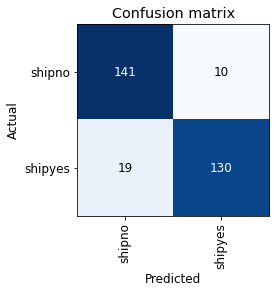

In [53]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

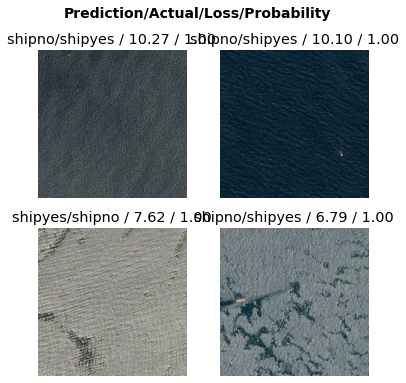

In [54]:
interp.plot_top_losses(4, nrows=2)

In [ ]:
# cleaner = ImageClassifierCleaner(learn)
# cleaner

In [ ]:
#hide
# for idx in cleaner.delete(): cleaner.fns[idx].unlink()
# for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

## Viewing Activations and Labels
notebook 05

In [38]:
x,y = dls.one_batch()

In [39]:
y

TensorCategory([0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0],
       device='cuda:0')

In [40]:
preds,_ = learn.get_preds(dl=[(x,y)])
preds[0]

tensor([0.9522, 0.0478])

In [41]:
len(preds[0]),preds[0].sum()

(2, tensor(1.0000))

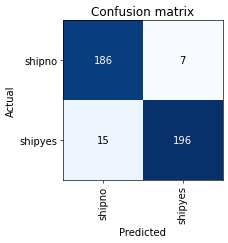

In [42]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(4,4), dpi=60)

In [71]:
interp.most_confused(min_val=5)

[('shipyes', 'shipno', 24), ('shipno', 'shipyes', 16)]

In [43]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256

In [44]:
learn.summary()

Sequential (Input shape: ['64 x 3 x 256 x 256'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               64 x 64 x 128 x 128  9,408      True      
________________________________________________________________
BatchNorm2d          64 x 64 x 128 x 128  128        True      
________________________________________________________________
ReLU                 64 x 64 x 128 x 128  0          False     
________________________________________________________________
MaxPool2d            64 x 64 x 64 x 64    0          False     
________________________________________________________________
Conv2d               64 x 64 x 64 x 64    4,096      True      
________________________________________________________________
BatchNorm2d          64 x 64 x 64 x 64    128        True      
________________________________________________________________
Conv2d               64 x 64 x 64 x 64    36,864     True      
_________________________________________________

In [45]:
mdl = learn.model

In [46]:
mdl[0]

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [47]:
mdl[1]

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten(full=False)
  (2): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=4096, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=2, bias=False)
)

In [48]:
mdl[0][4]

Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (downsample): Sequential(
      (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): Bottleneck(
    (conv1): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, ke

In [49]:
mdl[0][1]

BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

In [50]:
mdl[0][0]

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

In [51]:
mdl[0][0].weight.shape

torch.Size([64, 3, 7, 7])

In [52]:
mdl[0][4][0].conv1

Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)

In [57]:
mdl[0][4][1].conv1

Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)

In [53]:
mdl[0][4][0].conv1.weight.shape

torch.Size([64, 64, 1, 1])

In [130]:
learn.model.children??

In [54]:
# learn.model.classifier[0].weight
learn.model[0][:-2]

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [177]:
# sd = learn.model.state_dict()
# print(sd.keys())

Printing Layer 1:  Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
Weights are: (64, 3, 7, 7)
Weights after minmax_scale(ravel().reshape() are: (64, 3, 7, 7)
Rolled weights are:  (7, 7, 3)
Rolled weights are:  (7, 7, 3)
Rolled weights are:  (7, 7, 3)
Rolled weights are:  (7, 7, 3)
Rolled weights are:  (7, 7, 3)
Rolled weights are:  (7, 7, 3)
Rolled weights are:  (7, 7, 3)
Rolled weights are:  (7, 7, 3)
Rolled weights are:  (7, 7, 3)
Rolled weights are:  (7, 7, 3)
Rolled weights are:  (7, 7, 3)
Rolled weights are:  (7, 7, 3)
Rolled weights are:  (7, 7, 3)
Rolled weights are:  (7, 7, 3)
Rolled weights are:  (7, 7, 3)
Rolled weights are:  (7, 7, 3)
Rolled weights are:  (7, 7, 3)
Rolled weights are:  (7, 7, 3)
Rolled weights are:  (7, 7, 3)
Rolled weights are:  (7, 7, 3)
Rolled weights are:  (7, 7, 3)
Rolled weights are:  (7, 7, 3)
Rolled weights are:  (7, 7, 3)
Rolled weights are:  (7, 7, 3)
Rolled weights are:  (7, 7, 3)
Rolled weights are:  (7, 7, 3)
Rolled 

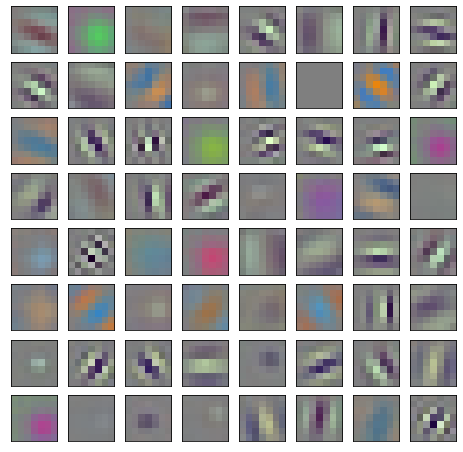

In [55]:
from sklearn.preprocessing import minmax_scale

def visualize_first_layer(learn):
    conv1 = list(learn.model.children())[0][0]
    print('Printing Layer 1: ', conv1)
    weights = conv1.weight.data.cpu().numpy()
    print('Weights are:', weights.shape)
    weights_shape = weights.shape
    weights = minmax_scale(weights.ravel()).reshape(weights_shape)
    print('Weights after minmax_scale(ravel().reshape() are:', weights.shape)
    fig, axes = plt.subplots(8, 8, figsize=(8,8))
    for i, ax in enumerate(axes.flat):
        tmp = np.rollaxis(weights[i], 0, 3)
        ax.imshow(tmp)
        print('Rolled weights are: ', tmp.shape)
        # ax.imshow(np.rollaxis(weights[i], 0, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

visualize_first_layer(learn)

Layer 2 shape  is: Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
Weights shape is: (64, 64, 1, 1)
Raveled Weights shape is: (64, 64, 1, 1)
0 X Weights are: (64, 64, 1, 1)
weights[i].shape (64, 1, 1)
tmpXY (64, 62, 1, 1)
1 X Weights are: (64, 64, 1, 1)
weights[i].shape (64, 1, 1)
tmpXY (64, 62, 1, 1)
2 X Weights are: (64, 64, 1, 1)
weights[i].shape (64, 1, 1)
tmpXY (64, 62, 1, 1)
3 X Weights are: (64, 64, 1, 1)
weights[i].shape (64, 1, 1)
tmpXY (64, 62, 1, 1)
4 X Weights are: (64, 64, 1, 1)
weights[i].shape (64, 1, 1)
tmpXY (64, 62, 1, 1)
5 X Weights are: (64, 64, 1, 1)
weights[i].shape (64, 1, 1)
tmpXY (64, 62, 1, 1)
6 X Weights are: (64, 64, 1, 1)
weights[i].shape (64, 1, 1)
tmpXY (64, 62, 1, 1)
7 X Weights are: (64, 64, 1, 1)
weights[i].shape (64, 1, 1)
tmpXY (64, 62, 1, 1)
8 X Weights are: (64, 64, 1, 1)
weights[i].shape (64, 1, 1)
tmpXY (64, 62, 1, 1)
9 X Weights are: (64, 64, 1, 1)
weights[i].shape (64, 1, 1)
tmpXY (64, 62, 1, 1)
10 X Weights are: (64, 64, 1, 1)
we

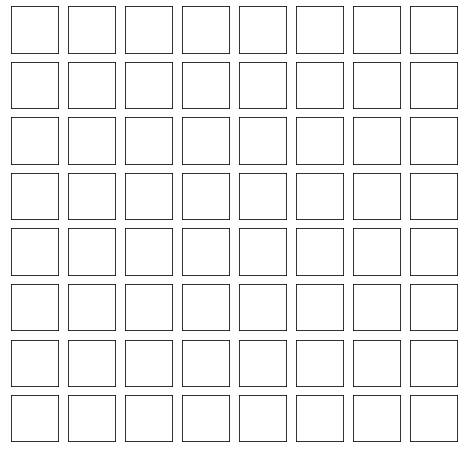

In [56]:
import numpy as np

from sklearn.preprocessing import minmax_scale

# HBA TEST
def visualize_first_layer(learn):
    conv1 = mdl[0][4][0].conv1
    print("Layer 2 shape  is:", conv1)
    weights = conv1.weight.data.cpu().numpy()
    print("Weights shape is:", weights.shape)
    weights_shape = weights.shape
    weights = minmax_scale(weights.ravel()).reshape(weights_shape)
    print("Raveled Weights shape is:", weights.ravel().reshape(weights_shape).shape)
    fig, axes = plt.subplots(8, 8, figsize=(8,8))
    for i, ax in enumerate(axes.flat):
        print (i, "X Weights are:",  weights.shape)
        #hba = np.rollaxis(weights[i], 0, 3)
        #print ("Rolled weights are", hba.shape)
        print("weights[i].shape", weights[i].shape)
        
        #tmpXY = weights[i][i]

        tmpXY = weights
        tmpXY = np.delete(tmpXY, np.s_[1:3], axis=1)  

        print ("tmpXY",tmpXY[:,:].shape)
        # ax.imshow(tmpXY)
        # ax.imshow(np.transpose(weights[i],1,2))
        
        # btch, x, y = weights[i].split() 
        
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        
visualize_first_layer(learn)

## Turning Your Model into an Online Application

### Using the Model for Inference

In [ ]:
learn.export()

In [ ]:
path = Path()
path.ls(file_exts='.pkl')

In [ ]:
learn_inf = load_learner(path/'export.pkl')

In [ ]:
learn_inf.predict('images/grizzly.jpg')

In [ ]:
learn_inf.dls.vocab

### Creating a Notebook App from the Model

In [ ]:
btn_upload = widgets.FileUpload()
btn_upload

In [ ]:
#hide
# For the book, we can't actually click an upload button, so we fake it
btn_upload = SimpleNamespace(data = ['images/grizzly.jpg'])

In [ ]:
img = PILImage.create(btn_upload.data[-1])

In [ ]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

In [ ]:
pred,pred_idx,probs = learn_inf.predict(img)

In [ ]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

In [ ]:
btn_run = widgets.Button(description='Classify')
btn_run

In [ ]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [ ]:
#hide
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

In [ ]:
VBox([widgets.Label('Select your bear!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

### Turning Your Notebook into a Real App

In [ ]:
#hide
# !pip install voila
# !jupyter serverextension enable voila —sys-prefix

### Deploying your app

## How to Avoid Disaster

### Unforeseen Consequences and Feedback Loops

## Get Writing!

## Questionnaire

1. Provide an example of where the bear classification model might work poorly in production, due to structural or style differences in the training data.
1. Where do text models currently have a major deficiency?
1. What are possible negative societal implications of text generation models?
1. In situations where a model might make mistakes, and those mistakes could be harmful, what is a good alternative to automating a process?
1. What kind of tabular data is deep learning particularly good at?
1. What's a key downside of directly using a deep learning model for recommendation systems?
1. What are the steps of the Drivetrain Approach?
1. How do the steps of the Drivetrain Approach map to a recommendation system?
1. Create an image recognition model using data you curate, and deploy it on the web.
1. What is `DataLoaders`?
1. What four things do we need to tell fastai to create `DataLoaders`?
1. What does the `splitter` parameter to `DataBlock` do?
1. How do we ensure a random split always gives the same validation set?
1. What letters are often used to signify the independent and dependent variables?
1. What's the difference between the crop, pad, and squish resize approaches? When might you choose one over the others?
1. What is data augmentation? Why is it needed?
1. What is the difference between `item_tfms` and `batch_tfms`?
1. What is a confusion matrix?
1. What does `export` save?
1. What is it called when we use a model for getting predictions, instead of training?
1. What are IPython widgets?
1. When might you want to use CPU for deployment? When might GPU be better?
1. What are the downsides of deploying your app to a server, instead of to a client (or edge) device such as a phone or PC?
1. What are three examples of problems that could occur when rolling out a bear warning system in practice?
1. What is "out-of-domain data"?
1. What is "domain shift"?
1. What are the three steps in the deployment process?

### Further Research

1. Consider how the Drivetrain Approach maps to a project or problem you're interested in.
1. When might it be best to avoid certain types of data augmentation?
1. For a project you're interested in applying deep learning to, consider the thought experiment "What would happen if it went really, really well?"
1. Start a blog, and write your first blog post. For instance, write about what you think deep learning might be useful for in a domain you're interested in.